In [1]:
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision.transforms.transforms import ToPILImage
from skimage import io

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os

#Custom models
from Model.device import device
from Model.custom_dataset import CustomDataTransform
from Model.custom_dataset_test import CustomDataTransform_test

from Model.generator import Generator
from Model.discriminator import Discriminator

from Model.train_disc import train_discriminator
from Model.train_gen import train_generator

from Model.train_step import train_step
from Model.valid_step import valid_step
from Model.test_step import test_step
from Model.visualization import visual

C:\Users\yaigo\Anaconda3\envs\Exponenta\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\yaigo\Anaconda3\envs\Exponenta\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
batch_size = 14
part = 0.7
alpha = 0
reduce = 0.9
patience = 30

lr_d = 2e-3
lr_g = 2e-3
weight_decay=1e-6
v_lambda = 100
epoches = 100

G_loss_epoche_train = []
D_loss_epoche_train = []
G_loss_batch_train = []
D_loss_batch_train = []

G_loss_epoche_valid = []
D_loss_epoche_valid = []
G_loss_batch_valid = []
D_loss_batch_valid = []

G_loss_epoche_test = []
D_loss_epoche_test = []
G_loss_batch_test = []
D_loss_batch_test = []

common_list = [v_lambda, 
                G_loss_epoche_train, D_loss_epoche_train, 
                G_loss_batch_train, D_loss_batch_train,
                G_loss_epoche_valid,
                D_loss_epoche_valid,
                G_loss_batch_valid,
                D_loss_batch_valid]

common_list_test = [v_lambda,
                    G_loss_epoche_test,
                    D_loss_epoche_test,
                    G_loss_batch_test,
                    D_loss_batch_test]

In [3]:
device = device()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [4]:
#for train and valid
source_dir = 'data/heart_data/undersampled_heart_images'
list_dir = os.listdir(source_dir)
list_pd = []
for file_name in list_dir:
    list_pd.append(file_name)
df = pd.DataFrame(list_pd)

x_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

y_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

dataset = CustomDataTransform(df, features_transform=x_transform, label_transform=y_transform)

train_lenght = int(len(dataset)*part)
rest_lenght = int(len(dataset) - train_lenght)

valid_lenght = int(rest_lenght*0.5)
test_lenght = int(rest_lenght - valid_lenght)

train_set, valid_and_test_set = random_split(dataset, [train_lenght, rest_lenght])
valid_set, test_set = random_split(valid_and_test_set, [valid_lenght, test_lenght])

train_loader = DataLoader(train_set, batch_size=batch_size, drop_last=False, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, drop_last=False, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, drop_last=False, shuffle=True)

print(f'Length of train is {len(train_set)}')
print(f'Length of valid is {len(valid_set)}')
print(f'Length of test is {len(test_set)}')

Length of train is 1150
Length of valid is 246
Length of test is 247


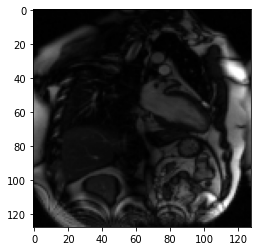

In [5]:
plt.imshow(train_set[0][1][0], cmap='gray')

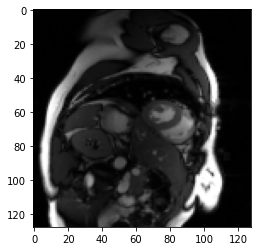

In [6]:
plt.imshow(valid_set[0][1][0], cmap='gray')

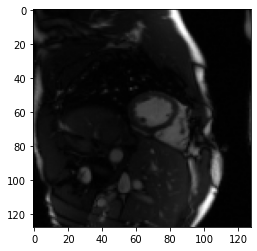

In [7]:
plt.imshow(test_set[0][1][0], cmap='gray')

In [8]:
def init_all(model, init_func, *params, **kwargs):
    for p in model.parameters():
        init_func(p, *params, **kwargs)

disc = Discriminator(in_channels=2).to(device)
init_all(disc, torch.nn.init.normal_, mean=0.0, std=0.001)

gen = Generator(in_channels=1, features=64).to(device)
init_all(gen, torch.nn.init.normal_, mean=0.0, std=0.001)

In [9]:
#Функции оптимизации
opt_disc = torch.optim.Adam(disc.parameters(), lr = lr_d, weight_decay=weight_decay)
opt_gen = torch.optim.Adam(gen.parameters(), lr = lr_g, weight_decay=weight_decay)

BCE_criterion = nn.BCELoss()
Loss = nn.L1Loss() #nn.L1Loss()

#scheduler_gen = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_gen, mode = 'min', factor = 0.8, patience = 10, threshold = 1e-3,verbose = 'True')
#scheduler_dis = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_disc, mode = 'min', factor = 0.8, patience = 10, threshold = 1e-3,verbose = 'True')
#scheduler_gen = torch.optim.lr_scheduler.CosineAnnealingLR(opt_gen, T_max=10, eta_min=0, last_epoch=- 1, verbose=True)
#scheduler_dis = torch.optim.lr_scheduler.CosineAnnealingLR(opt_disc, T_max=10, eta_min=0, last_epoch=- 1, verbose=True)

Epoche: 1
G_train_loss: 8.859956241515746	 D_train_loss: 0.6931473268083779
G_valid_loss: 6.933485296037462	 D_valid_loss: 0.6931471824645996
G_test_loss: 6.962359428405762	 D_test_loss: 0.6931471824645996


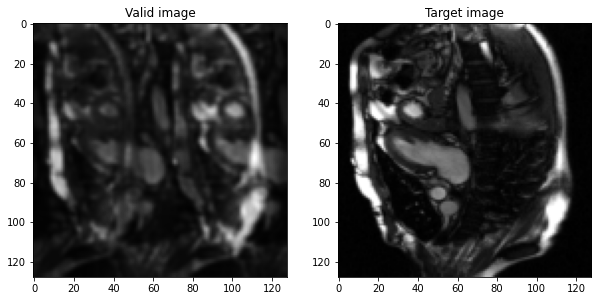

Epoche: 2
G_train_loss: 7.194061214665332	 D_train_loss: 0.6931472632540278
G_valid_loss: 5.987018850114611	 D_valid_loss: 0.6931471824645996
G_test_loss: 6.035273101594713	 D_test_loss: 0.6931471824645996


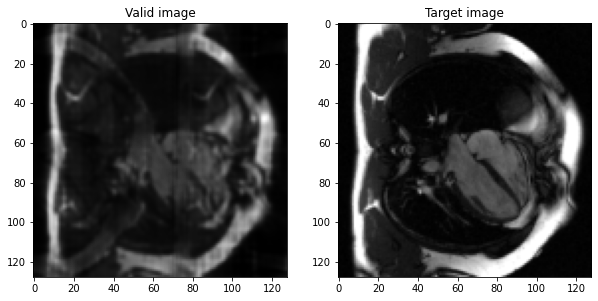

Epoche: 3
G_train_loss: 6.149089787379805	 D_train_loss: 0.6931472425479965
G_valid_loss: 5.197473243430808	 D_valid_loss: 0.6931471824645996
G_test_loss: 5.2291749671653465	 D_test_loss: 0.6931471824645996


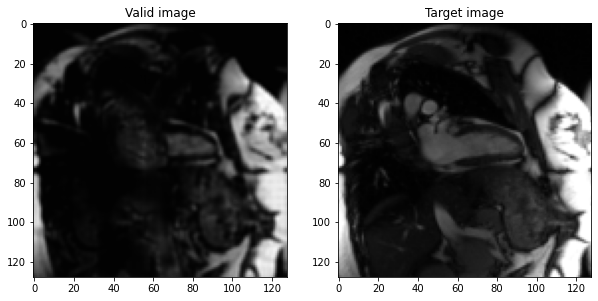

Epoche: 4
G_train_loss: 5.4603992284062395	 D_train_loss: 0.6931472329131092
G_valid_loss: 4.696542799472809	 D_valid_loss: 0.6931471824645996
G_test_loss: 4.72320317890909	 D_test_loss: 0.6931471824645996


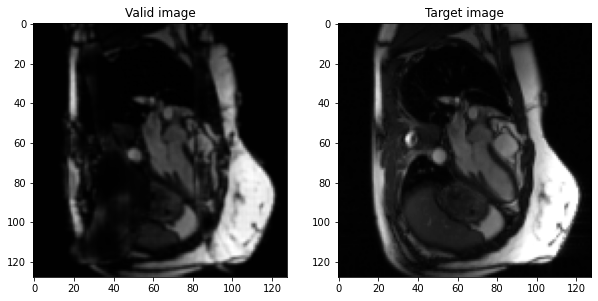

Epoche: 5
G_train_loss: 4.977174939304949	 D_train_loss: 0.6931472259831716
G_valid_loss: 4.360486968358358	 D_valid_loss: 0.6931471824645996
G_test_loss: 4.391014197137621	 D_test_loss: 0.6931471824645996


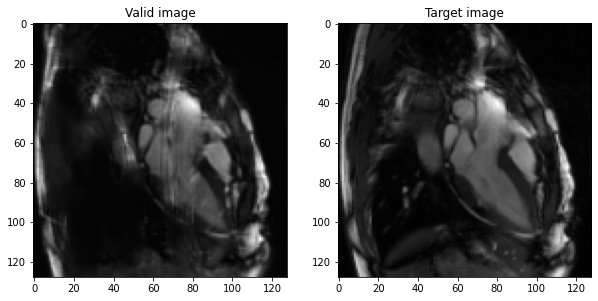

Epoche: 6
G_train_loss: 4.623120829283473	 D_train_loss: 0.6931472204057089
G_valid_loss: 4.076287772920397	 D_valid_loss: 0.6931471824645996
G_test_loss: 4.094041413731045	 D_test_loss: 0.6931471824645996


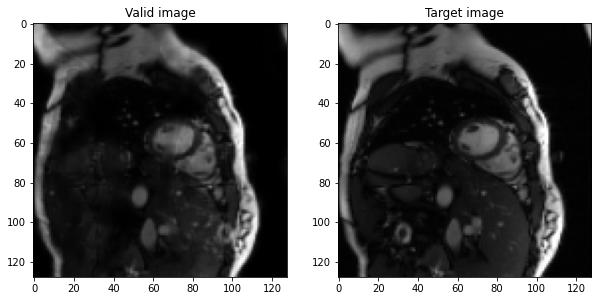

Epoche: 7
G_train_loss: 4.354340050593916	 D_train_loss: 0.6931472173451146
G_valid_loss: 3.9490425756999423	 D_valid_loss: 0.6931471905064961
G_test_loss: 3.9763179506574358	 D_test_loss: 0.6931471905064961


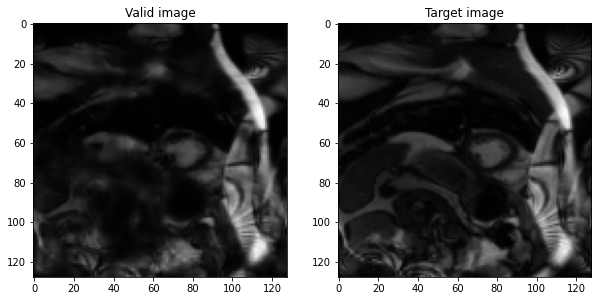

Epoche: 8
G_train_loss: 4.136721137417368	 D_train_loss: 0.6931472154087331
G_valid_loss: 3.784995017780198	 D_valid_loss: 0.6931471895012591
G_test_loss: 3.8213232275512485	 D_test_loss: 0.6931471895012591


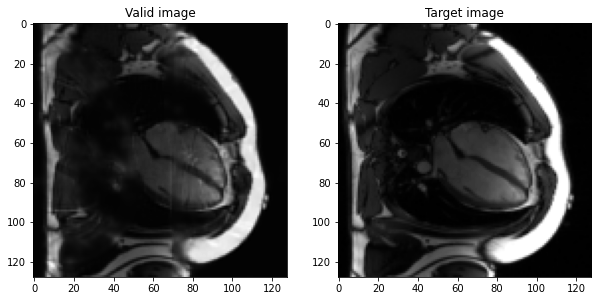

Epoche: 9
G_train_loss: 3.9486206166715507	 D_train_loss: 0.6931472139026585
G_valid_loss: 3.643432973343649	 D_valid_loss: 0.6931471887194081
G_test_loss: 3.6827015817901234	 D_test_loss: 0.6931471887194081


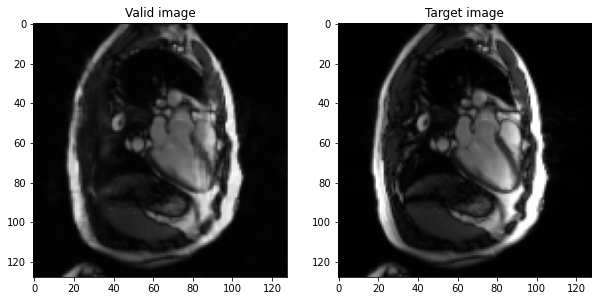

Epoche: 10
G_train_loss: 3.7835273754165835	 D_train_loss: 0.6931472125541733
G_valid_loss: 3.5203864521450465	 D_valid_loss: 0.6931471880939272
G_test_loss: 3.5647465149561564	 D_test_loss: 0.6931471880939272


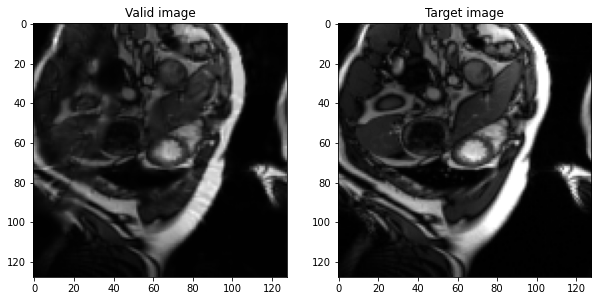

Epoche: 11
G_train_loss: 3.6574441198451364	 D_train_loss: 0.6931472115814359
G_valid_loss: 3.393199566638831	 D_valid_loss: 0.6931471875821701
G_test_loss: 3.4360845365909616	 D_test_loss: 0.6931471875821701


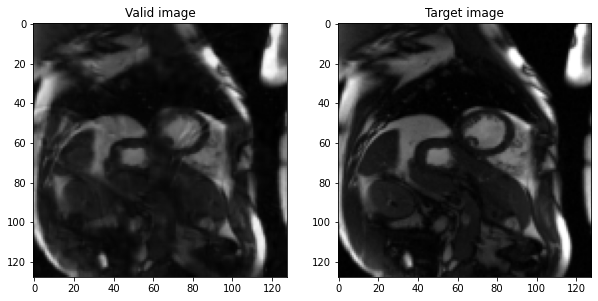

Epoche: 12
G_train_loss: 3.5315842396284203	 D_train_loss: 0.6931472109503536
G_valid_loss: 3.2846927526924343	 D_valid_loss: 0.6931471871557059
G_test_loss: 3.3292404076567403	 D_test_loss: 0.6931471871557059


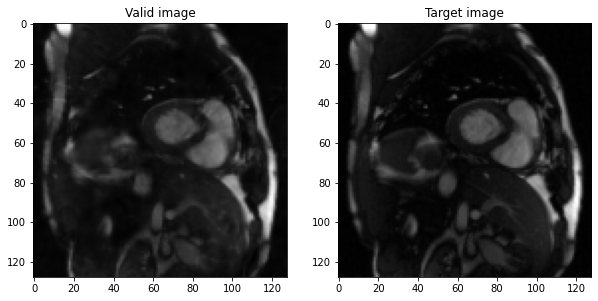

Epoche: 13
G_train_loss: 3.4316422237744475	 D_train_loss: 0.6931472100296763
G_valid_loss: 3.201382975802462	 D_valid_loss: 0.6931471911251036
G_test_loss: 3.2398823025899057	 D_test_loss: 0.6931471911251036


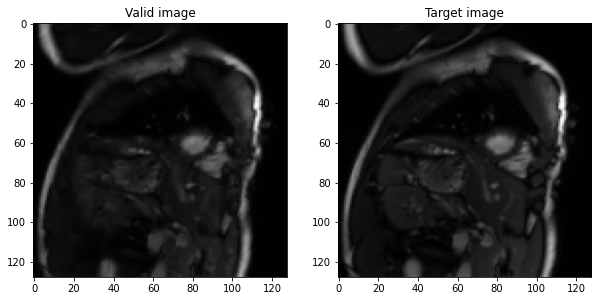

Epoche: 14
G_train_loss: 3.331319736634187	 D_train_loss: 0.6931472095482937
G_valid_loss: 3.1093941766118247	 D_valid_loss: 0.6931471905064961
G_test_loss: 3.148377832439211	 D_test_loss: 0.6931471905064961


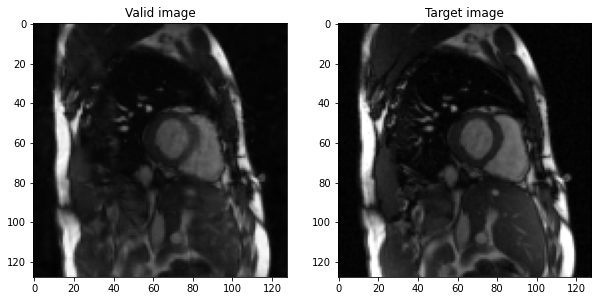

Epoche: 15
G_train_loss: 3.2401427804226857	 D_train_loss: 0.6931472085087175
G_valid_loss: 3.030730619253936	 D_valid_loss: 0.6931471937232547
G_test_loss: 3.0690169784757826	 D_test_loss: 0.6931471937232547


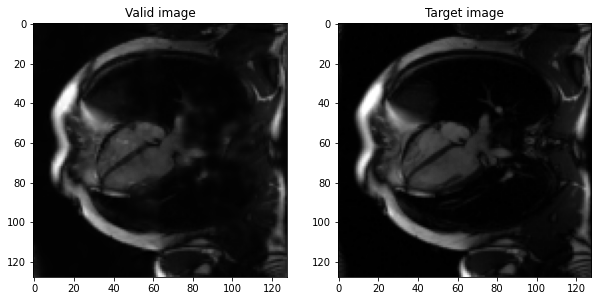

Epoche: 16
G_train_loss: 3.156520893685071	 D_train_loss: 0.6931472081825676
G_valid_loss: 2.962622723645634	 D_valid_loss: 0.6931471965379186
G_test_loss: 3.000679429206583	 D_test_loss: 0.6931471965379186


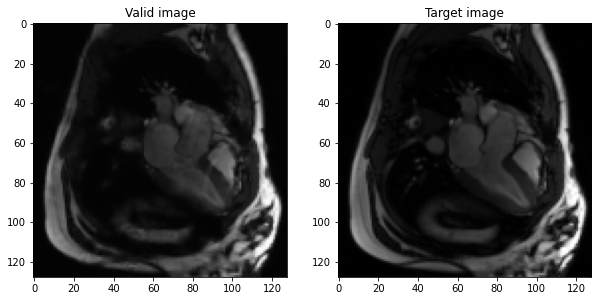

Epoche: 17
G_train_loss: 3.0778989596708204	 D_train_loss: 0.6931472077258168
G_valid_loss: 2.8987100541202073	 D_valid_loss: 0.6931471957100762
G_test_loss: 2.9360954282330534	 D_test_loss: 0.6931471957100762


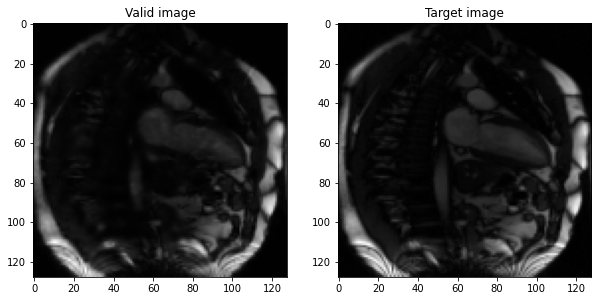

Epoche: 18
G_train_loss: 3.0059191584587097	 D_train_loss: 0.6931472074395043
G_valid_loss: 2.838809343031895	 D_valid_loss: 0.6931471949742164
G_test_loss: 2.8771238558822207	 D_test_loss: 0.6931471949742164


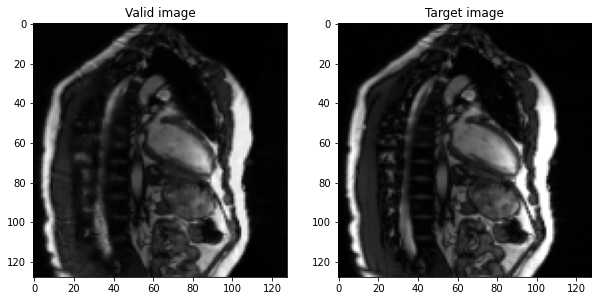

Epoche: 19
G_train_loss: 2.938004272454285	 D_train_loss: 0.6931472071077375
G_valid_loss: 2.778928804815861	 D_valid_loss: 0.6931471943158155
G_test_loss: 2.8145160751733167	 D_test_loss: 0.6931471943158155


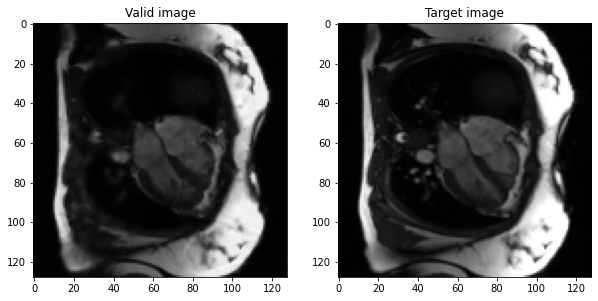

Epoche: 20
G_train_loss: 2.877707336609622	 D_train_loss: 0.6931472067732409
G_valid_loss: 2.724436233109898	 D_valid_loss: 0.6931471937232547
G_test_loss: 2.7593550930420556	 D_test_loss: 0.6931471937232547


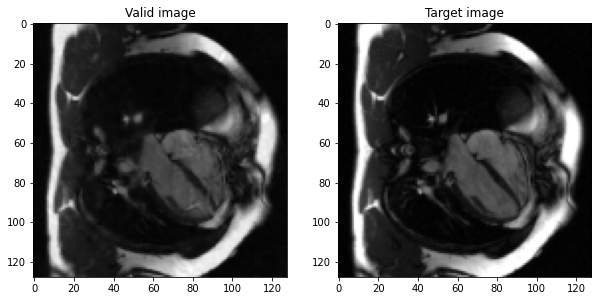

Epoche: 21
G_train_loss: 2.8214758386983996	 D_train_loss: 0.6931472062996182
G_valid_loss: 2.6781105657733937	 D_valid_loss: 0.6931471958677605
G_test_loss: 2.7128057845685847	 D_test_loss: 0.6931471958677605


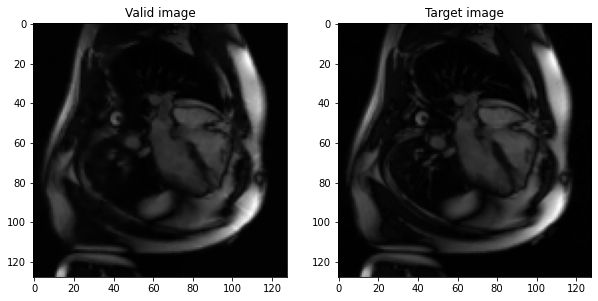

Epoche: 22
G_train_loss: 2.7707217992461914	 D_train_loss: 0.6931472061628319
G_valid_loss: 2.6328722678049647	 D_valid_loss: 0.6931471952585259
G_test_loss: 2.6658103306486147	 D_test_loss: 0.6931471952585259


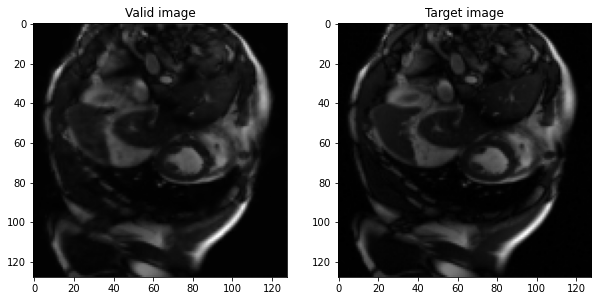

Epoche: 23
G_train_loss: 2.7238478114806024	 D_train_loss: 0.6931472057569333
G_valid_loss: 2.594923169716545	 D_valid_loss: 0.693147197149802
G_test_loss: 2.625698615387442	 D_test_loss: 0.693147197149802


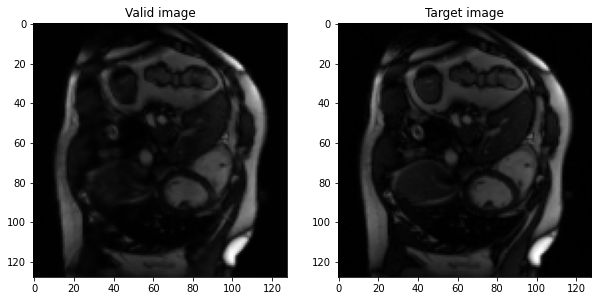

Epoche: 24
G_train_loss: 2.6792503818570372	 D_train_loss: 0.6931472054447037
G_valid_loss: 2.5548237084790513	 D_valid_loss: 0.6931471965379186
G_test_loss: 2.5848102354341083	 D_test_loss: 0.6931471965379186


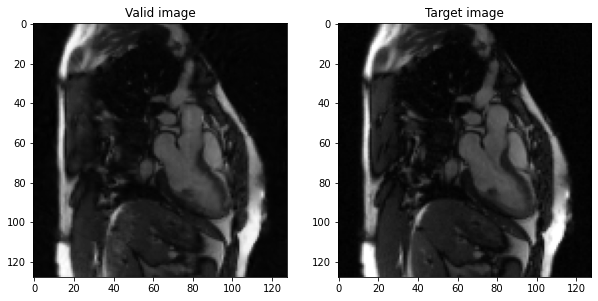

Epoche: 25
G_train_loss: 2.638921749792903	 D_train_loss: 0.693147205100002
G_valid_loss: 2.557768814033932	 D_valid_loss: 0.6931471959749858
G_test_loss: 2.585526827176412	 D_test_loss: 0.6931471959749858


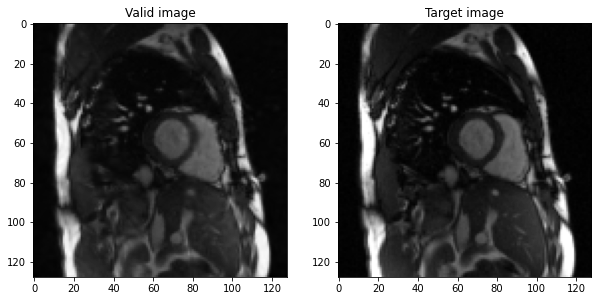

Epoche: 26
G_train_loss: 2.6082104666571135	 D_train_loss: 0.6931472049751582
G_valid_loss: 2.5359457687944427	 D_valid_loss: 0.6931471976204815
G_test_loss: 2.5624949066047993	 D_test_loss: 0.6931471976204815


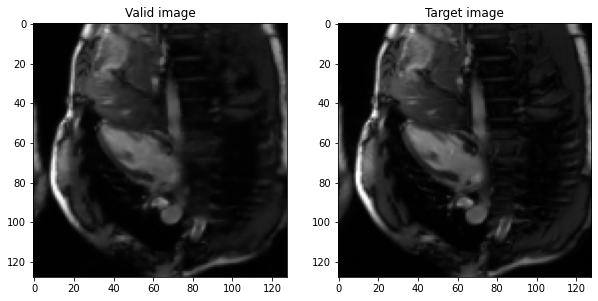

Epoche: 27
G_train_loss: 2.576904689451777	 D_train_loss: 0.693147204859562
G_valid_loss: 2.50460731173739	 D_valid_loss: 0.6931471991440887
G_test_loss: 2.5313608918660955	 D_test_loss: 0.6931471991440887


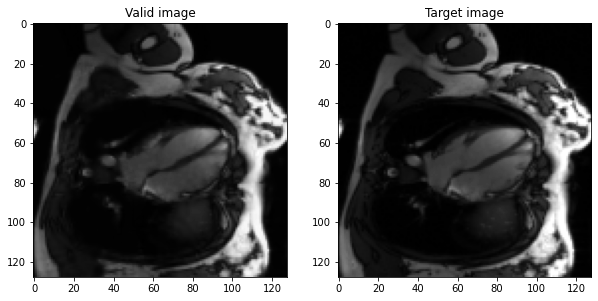

Epoche: 28
G_train_loss: 2.5432408583348876	 D_train_loss: 0.6931472049574023
G_valid_loss: 2.472683941324552	 D_valid_loss: 0.6931471985483927
G_test_loss: 2.499136261523716	 D_test_loss: 0.6931471985483927


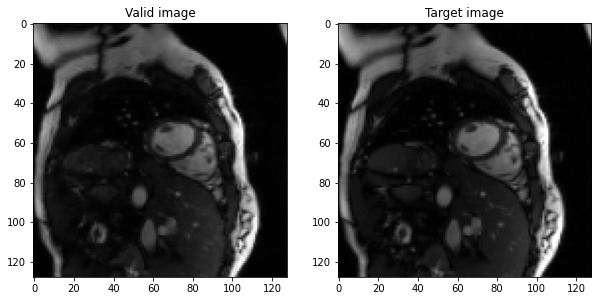

Epoche: 29
G_train_loss: 2.5096973341730653	 D_train_loss: 0.6931472047265753
G_valid_loss: 2.4491847015888757	 D_valid_loss: 0.6931471979937791
G_test_loss: 2.4753207205812595	 D_test_loss: 0.6931471979937791


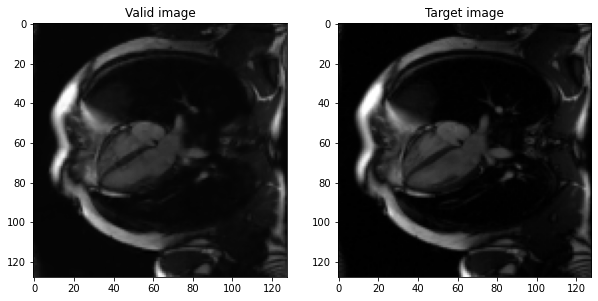

Epoche: 30
G_train_loss: 2.4793023739473887	 D_train_loss: 0.6931472045590121
G_valid_loss: 2.4250807894600763	 D_valid_loss: 0.6931471993525823
G_test_loss: 2.4513343078118783	 D_test_loss: 0.6931471993525823


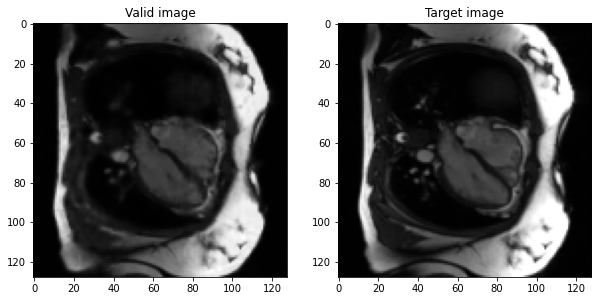

Epoche: 31
G_train_loss: 2.4537498851346915	 D_train_loss: 0.6931472044022594
G_valid_loss: 2.395907662675372	 D_valid_loss: 0.6931472006237208
G_test_loss: 2.421389481927332	 D_test_loss: 0.6931472006237208


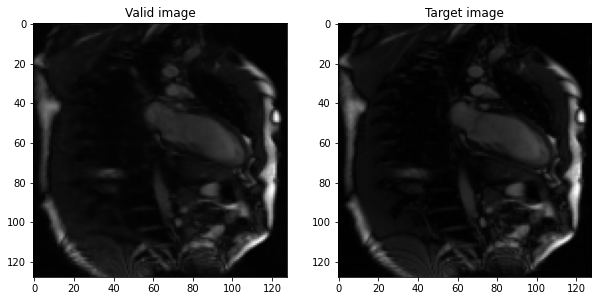

Epoche: 32
G_train_loss: 2.425849233720317	 D_train_loss: 0.6931472043001867
G_valid_loss: 2.3690035392840705	 D_valid_loss: 0.6931472000562482
G_test_loss: 2.394108744131194	 D_test_loss: 0.6931472000562482


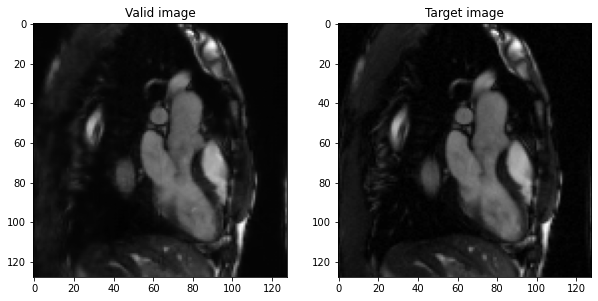

Epoche: 33
G_train_loss: 2.4009276188912727	 D_train_loss: 0.6931472041825388
G_valid_loss: 2.3479520740733806	 D_valid_loss: 0.693147199523168
G_test_loss: 2.3727738078595815	 D_test_loss: 0.693147199523168


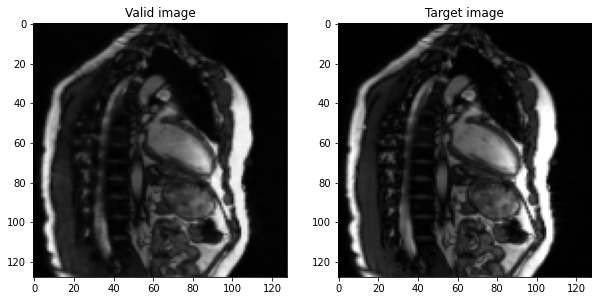

Epoche: 34
G_train_loss: 2.3761116352426	 D_train_loss: 0.6931472040718114
G_valid_loss: 2.324405989226173	 D_valid_loss: 0.69314720067713
G_test_loss: 2.348651407201306	 D_test_loss: 0.69314720067713


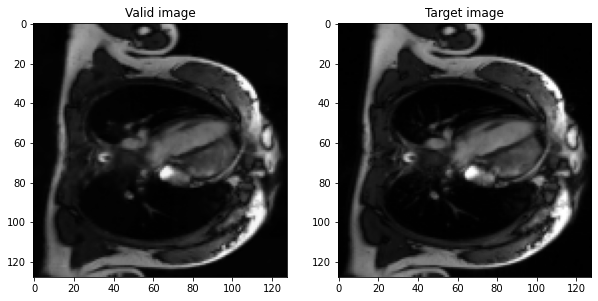

Epoche: 35
G_train_loss: 2.351109205835247	 D_train_loss: 0.6931472041315548
G_valid_loss: 2.3005210344753566	 D_valid_loss: 0.6931472001567719
G_test_loss: 2.3244237960331025	 D_test_loss: 0.6931472001567719


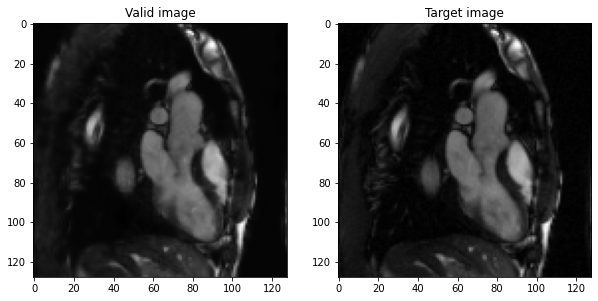

Epoche: 36
G_train_loss: 2.327161436778315	 D_train_loss: 0.6931472040483432
G_valid_loss: 2.2777679875309085	 D_valid_loss: 0.6931471996653227
G_test_loss: 2.3012827570423666	 D_test_loss: 0.6931471996653227


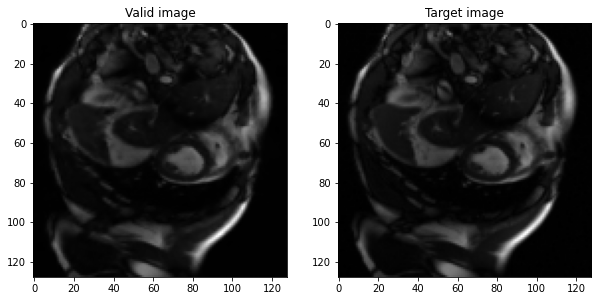

Epoche: 37
G_train_loss: 2.3038191303916493	 D_train_loss: 0.6931472040472648
G_valid_loss: 2.2586459388604037	 D_valid_loss: 0.6931471992004383
G_test_loss: 2.2809616184091426	 D_test_loss: 0.6931471992004383


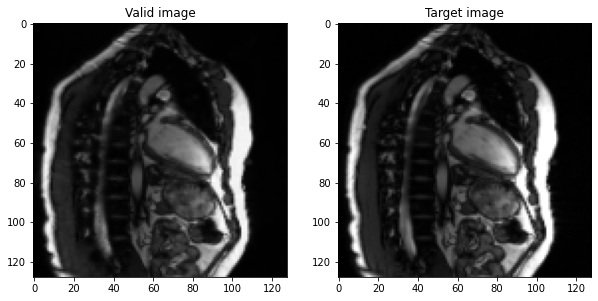

KeyboardInterrupt: 

In [10]:
for epoche in range(epoches):
    
    #train processing
    y_train_fake, y_true, g_mean_train_loss, d_mean_train_loss = train_step(train_discriminator, train_generator,
                                                                           train_loader, 
                                                                           BCE_criterion, 
                                                                           Loss, 
                                                                           gen, disc, 
                                                                           opt_disc, opt_gen, device, common_list, alpha
                                                                         )
    
    #validation checking
    y_valid_fake, y_valid_true, g_mean_valid_loss, d_mean_valid_loss = valid_step(valid_loader, 
                                                                                  BCE_criterion, 
                                                                                  Loss, 
                                                                                  gen, disc, device, common_list, alpha
                                                                                 )
    #testing checking
    y_test_fake, y_test_true, g_mean_test_loss, d_mean_test_loss = test_step(test_loader, 
                                                                              BCE_criterion, 
                                                                              Loss, 
                                                                              gen, disc, device, common_list_test, alpha
                                                                             )
    
    #if (epoche%patience == 0 and epoche != 0):
    #    lr_d = lr_d*reduce
    #    lr_g = lr_g*reduce
    #    opt_disc.param_groups[0]['lr'] = lr_d
    #    opt_gen.param_groups[0]['lr'] = lr_g
    #print('gen_lr: ',opt_disc.param_groups[0]['lr'])
    #print('dis_lr: ', opt_gen.param_groups[0]['lr']) 
    
    #scheduler_gen.step() #g_mean_train_loss,  g_mean_valid_loss
    #scheduler_dis.step() #d_mean_train_loss,  d_mean_valid_loss

    #print('gen_lr: ',scheduler_gen.optimizer.param_groups[0]['lr'])
    #print('dis_lr: ', scheduler_dis.optimizer.param_groups[0]['lr'])    
    print(f'Epoche: {epoche+1}\nG_train_loss: {g_mean_train_loss}\t D_train_loss: {d_mean_train_loss}')
    print(f'G_valid_loss: {g_mean_valid_loss}\t D_valid_loss: {d_mean_valid_loss}')
    print(f'G_test_loss: {g_mean_test_loss}\t D_test_loss: {d_mean_test_loss}')
     
    #Visualization
    visual(y_test_true, y_test_fake)

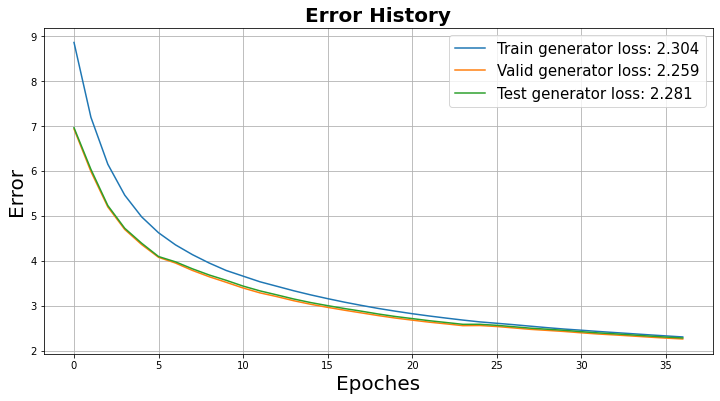

In [11]:
#Train and Valid Error Plot
fig, ax = plt.subplots()
ax.plot(G_loss_epoche_train, label = 'Train generator loss: ' + str(round(G_loss_epoche_train[-1], 3)))
ax.plot(G_loss_epoche_valid, label = 'Valid generator loss: ' + str(round(G_loss_epoche_valid[-1], 3)))
ax.plot(G_loss_epoche_test, label = 'Test generator loss: ' + str(round(G_loss_epoche_test[-1], 3)))

ax.legend(fontsize=15)
fig.set_figheight(6)
fig.set_figwidth(12)
plt.grid()
plt.title("Error History", fontsize= 20, fontweight='bold')
plt.xlabel("Epoches", fontsize= 20)
plt.ylabel("Error", fontsize= 20)
plt.rcParams.update({'font.size': 18})
plt.show()

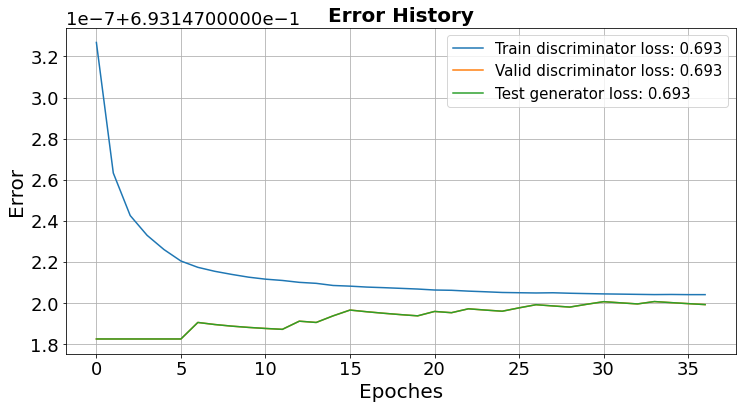

In [12]:
fig, ax = plt.subplots()
ax.plot(D_loss_epoche_train, label = 'Train discriminator loss: ' + str(round(D_loss_epoche_train[-1], 3)))
ax.plot(D_loss_epoche_valid, label = 'Valid discriminator loss: ' + str(round(D_loss_epoche_valid[-1], 3)))
ax.plot(D_loss_epoche_test, label = 'Test generator loss: ' + str(round(D_loss_epoche_test[-1], 3)))

ax.legend(fontsize=15)
fig.set_figheight(6)
fig.set_figwidth(12)
plt.grid()
plt.title("Error History", fontsize= 20, fontweight='bold')
plt.xlabel("Epoches", fontsize= 20)
plt.ylabel("Error", fontsize= 20)
plt.rcParams.update({'font.size': 18})
plt.show()

In [ ]:
# Saving model
PATH = 'learned_nets/GAN_Gen_extended_v2.pt'
torch.save(gen.state_dict(), PATH)

In [ ]:
#saving error list
import pickle

#train
with open('error_lists/G_loss_epoche_train_v2.txt', 'wb') as file:
    pickle.dump(G_loss_epoche_train, file)
with open('error_lists/D_loss_epoche_train_v2.txt', 'wb') as file:
    pickle.dump(D_loss_epoche_train, file)

#valid
with open('error_lists/G_loss_epoche_valid_v2.txt', 'wb') as file:
    pickle.dump(G_loss_epoche_valid, file)
with open('error_lists/D_loss_epoche_valid_v2.txt', 'wb') as file:
    pickle.dump(D_loss_epoche_valid, file)